LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [ ]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

In [ ]:
!pip install mosek 
!export PYTHONPATH="$PYTHONPATH:/content"

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem. 
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [ ]:
# Colab additional settings
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

First we generate return scenario data using Monte Carlo method based on the moments of historical prices.  

In [6]:
# Number of scenarios
T = 99999

# Mean and covariance of historical log-returns.  
m_log, S_log = compute_inputs(df_prices, return_log=True)

# Generate logarithmic return scenarios assuming normal distribution
scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, T)
    
# Convert logarithmic return scenarios to linear return scenarios 
scenarios_lin = np.exp(scenarios_log) - 1

# Scenario probabilities
p = np.ones(T) / T

We would like to optimize the 95% CVaR of the portfolio loss distribution.

In [7]:
# Confidence level
alpha = 0.95

In [8]:
# Primal CVaR formula (for testing)
def CVaR(alpha, p, q):
    # We need to be careful that math index starts from 1 but numpy starts from 0 (matters in formulas like ceil(alpha * T))
    T = q.shape[0]
    
    # Starting index 
    i_alpha = np.sort(np.nonzero(np.cumsum(p) >= alpha)[0])[0]

    # Weight of VaR component in CVaR
    lambda_alpha = (sum(p[:(i_alpha + 1)]) - alpha) / (1 - alpha)    
    
    # CVaR
    sort_idx = np.argsort(q)
    sorted_q = q[sort_idx]
    sorted_p = p[sort_idx]
    cvar = lambda_alpha * sorted_q[i_alpha] + np.dot(sorted_p[(i_alpha + 1):], sorted_q[(i_alpha + 1):]) / (1 - alpha)
    
    return cvar

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [9]:
# max(x, y) <= t
def maximum(M, x, y, t):
    M.constraint(Expr.sub(t, x), Domain.greaterThan(0.0))
    M.constraint(Expr.sub(t, y), Domain.greaterThan(0.0))
    

def EfficientFrontier(N, T, m, R, p, alpha, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings relative to the initial capital.
        # It is constrained to take only positive values. 
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1.0))
        
        # Auxiliary variables.
        t = M.variable("t", 1, Domain.unbounded())
        u = M.variable("u", T, Domain.unbounded())
        
        # Constraint modeling maximum
        maximum(M, Expr.sub(Expr.mul(-R, x), Expr.repeat(t, T, 0)), Expr.constTerm(T, 0.0), u)
        
        # Objective
        delta = M.parameter()
        cvar_term = Expr.add(t, Expr.mul(1/(1-alpha), Expr.dot(p, u)))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, cvar_term)))
        
        # Create DataFrame to store the results.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d)
        
            # Solve optimization
            M.solve()

            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = t.level()[0] + 1/(1-alpha) * np.dot(p, u.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)
            
            # Check CVaR value using primal formula
            cvar = CVaR(alpha, p, -R @ x.level())
            print(f"Relative difference between primal and dual CVaR (%): {(cvar - portfolio_risk) / portfolio_risk * 100}")

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [10]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, _ = compute_inputs(df_prices)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [11]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=2, num=20)[::-1]
df_result = EfficientFrontier(N, T, m, scenarios_lin, p, alpha, deltas)

Relative difference between primal and dual CVaR (%): -6.999369506468045e-10
Relative difference between primal and dual CVaR (%): -6.666708314479581e-10
Relative difference between primal and dual CVaR (%): 1.1618639217416219e-08
Relative difference between primal and dual CVaR (%): -7.946360592013031e-10
Relative difference between primal and dual CVaR (%): -1.0104297436496764e-09
Relative difference between primal and dual CVaR (%): -4.67754485239752e-10
Relative difference between primal and dual CVaR (%): 2.8933837563921657e-09
Relative difference between primal and dual CVaR (%): -6.633031019482053e-10
Relative difference between primal and dual CVaR (%): -7.516519526139052e-10
Relative difference between primal and dual CVaR (%): -1.1756637297507373e-09
Relative difference between primal and dual CVaR (%): -1.0465131915021535e-09
Relative difference between primal and dual CVaR (%): 3.909739646904952e-09
Relative difference between primal and dual CVaR (%): 1.7568393035783117e-0

Check the results.

In [12]:
df_result

,delta,obj,return,risk,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,-9.539738,0.362163,0.099019,0.0,0.0,0.082946,0.0,0.103628,0.582500,0.230925,0.0
1,69.519280,-6.521506,0.362595,0.099024,0.0,0.0,0.081388,0.0,0.104589,0.583920,0.230103,0.0
2,48.329302,-4.423088,0.363400,0.099039,0.0,0.0,0.077521,0.0,0.104457,0.587483,0.230539,0.0
3,33.598183,-2.963924,0.364704,0.099072,0.0,0.0,0.072002,0.0,0.106156,0.591885,0.229957,0.0
4,23.357215,-1.949086,0.366324,0.099130,0.0,0.0,0.064634,0.0,0.107357,0.597693,0.230316,0.0
5,16.237767,-1.242894,0.369501,0.099299,0.0,0.0,0.050694,0.0,0.111209,0.607845,0.230252,0.0
6,11.288379,-0.750719,0.373705,0.099609,0.0,0.0,0.032830,0.0,0.116624,0.622018,0.228529,0.0
7,7.847600,-0.407096,0.379059,0.100178,0.0,0.0,0.011418,0.0,0.124710,0.641017,0.222855,0.0
8,5.455595,-0.166700,0.382645,0.100694,0.0,0.0,0.000000,0.0,0.133931,0.654015,0.212054,0.0
9,3.792690,0.001021,0.384469,0.101102,0.0,0.0,0.000000,0.0,0.145657,0.661972,0.192371,0.0


## Visualize the results

Plot the efficient frontier.

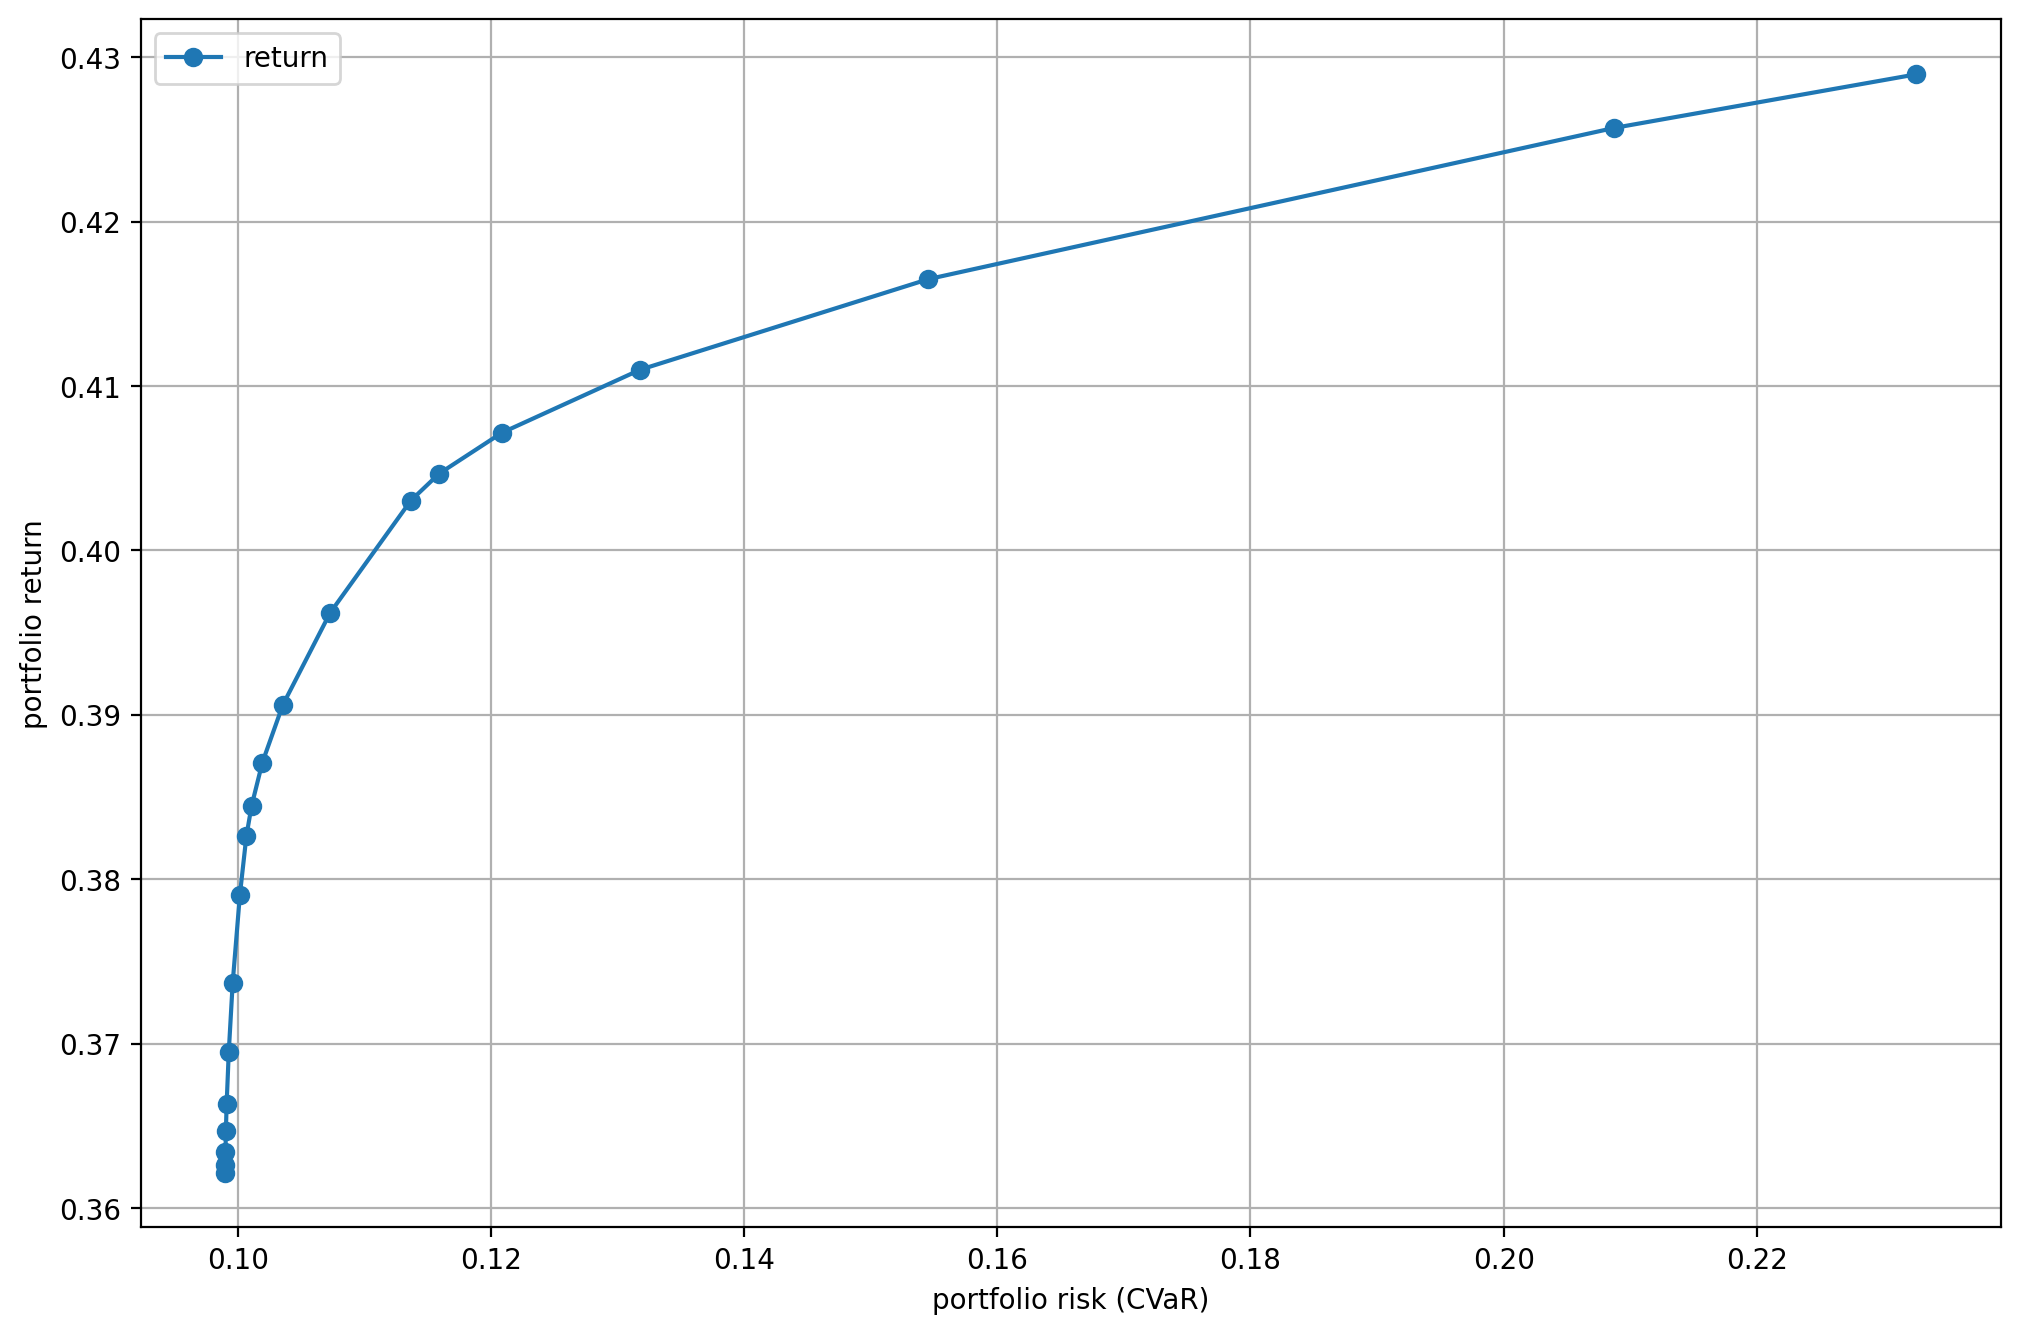

In [13]:
ax = df_result.plot(x="risk", y="return", style="-o", 
                    xlabel="portfolio risk (CVaR)", ylabel="portfolio return", grid=True)   
ax.legend(["return"]);

Plot the portfolio composition.

In [14]:
# Round small values to 0 to make plotting work
mask = np.absolute(df_result) < 1e-7
mask.iloc[:, :-8] = False
df_result[mask] = 0

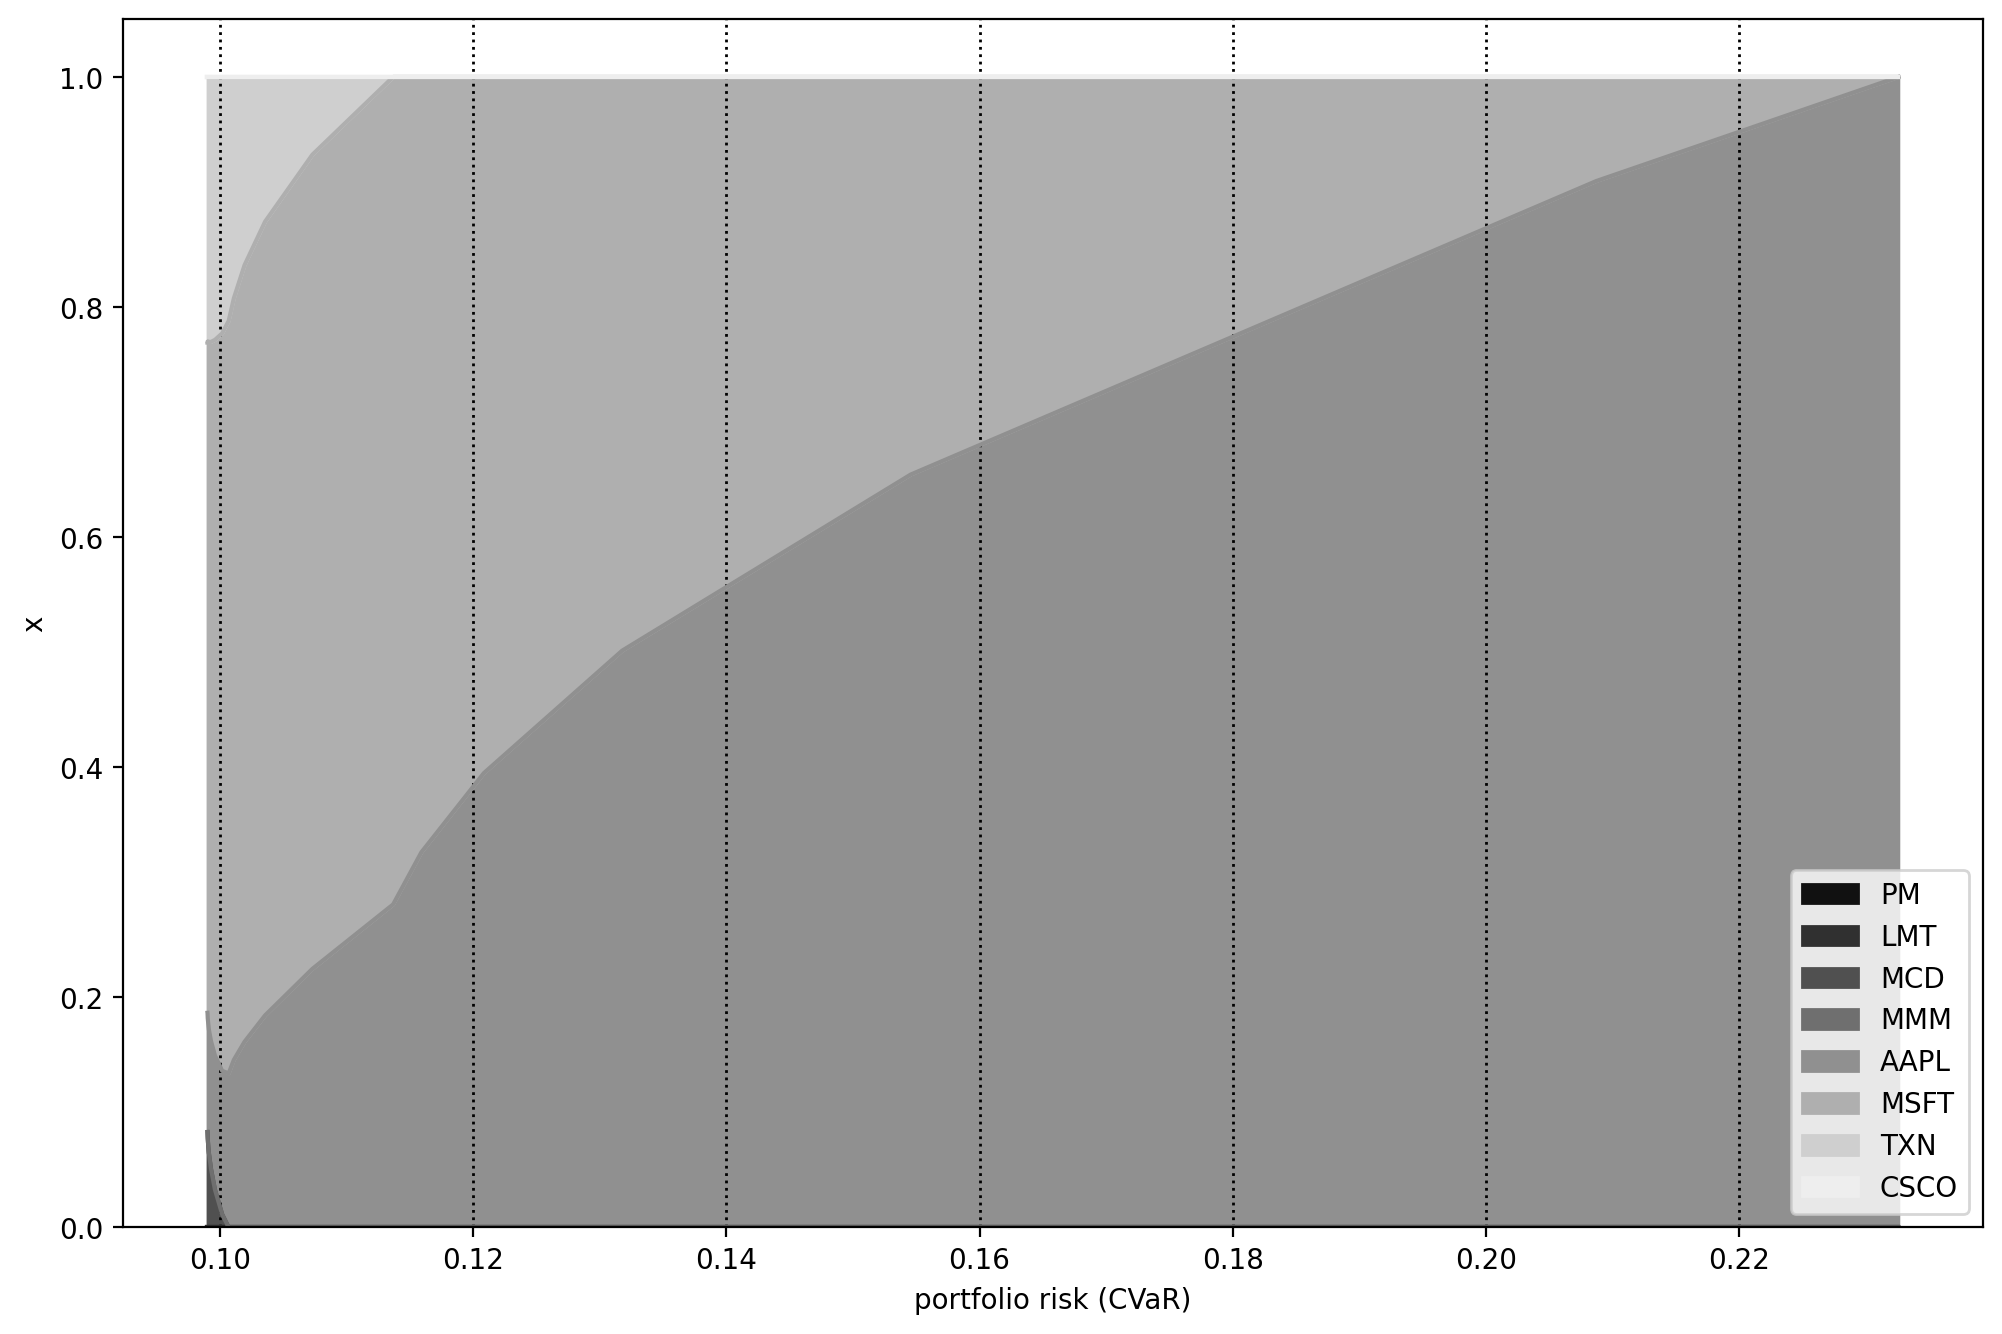

In [15]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = df_result.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (CVaR)', ylabel="x") 
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)